In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [7]:

torch.manual_seed(1)

EPOCH = 8
LR = 0.001
batch_size = 128
DOWNLOAD_MNIST = True
Device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False, transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)



In [8]:
# baseline
class FC_1(nn.Module):
    def __init__(self):
        super(FC_1, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
#         self.fc3 = nn.Linear(10, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 调整数据维度
        x = self.fc1(x)  
        x = F.relu(x)
        x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)

        output = x
        return output

In [9]:
# baseline plus
class FC_2(nn.Module):
    def __init__(self):
        super(FC_2, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        self.fc3 = nn.Linear(10, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 调整数据维度
        x = self.fc1(x)  
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        output = x
        return output

In [10]:

class Conv_net_base(nn.Module):
    def __init__(self):
        super(Conv_net_base, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2),  # h,w保持不变
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [11]:

class Conv_net_plus(nn.Module):
    def __init__(self):
        super(Conv_net_plus, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),  # h,w保持不变
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, padding=2),  # h,w保持不变
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [12]:

class Conv_net_plus_bn(nn.Module):
    def __init__(self):
        super(Conv_net_plus_bn, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),  # h,w保持不变
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 5, padding=2),  # h,w保持不变
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*7*7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [13]:

class Conv_net_plus_bn_dropout(nn.Module):
    def __init__(self):
        super(Conv_net_plus_bn_dropout, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),  # h,w保持不变
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            torch.nn.Dropout2d(p=0.1),
            nn.ReLU(),

            nn.Conv2d(16, 32, 5, padding=2),  # h,w保持不变
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            torch.nn.Dropout2d(p=0.1),
            nn.ReLU(),

            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            torch.nn.Dropout2d(p=0.1),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*7*7, 512),
            nn.BatchNorm1d(512),
            torch.nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [24]:

def train(network, save_name):

    optimizer = torch.optim.Adam(network.parameters(), lr=LR)
    # loss_func = nn.MSELoss()
    loss_func = nn.CrossEntropyLoss()
    best_val_acc = 0
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(EPOCH):
        loss_sum = 0
        acc_sum = 0
        print(f'EPOCH{epoch}\n-----------------')
        size = len(train_dataloader.dataset)

        network.train()
        for batch, item in enumerate(train_dataloader):

            # if batch == 4:  # 删除
            #     break

            pics, labels = item
            pics = pics.to(Device)
            labels = labels.to(Device)
            
            output = network(pics)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if batch % 150 == 0:
                loss_value, current = loss.item(), batch*len(pics)
                train_loss.append(loss_value)
                acc = (output.argmax(dim=1) == labels).sum().item() / len(pics)
                train_acc.append(acc)
                print(f'loss:{loss_value:>7f}  accuracy:{acc:>7f}  [{current:>5d}/{size:>5d}]')


        with torch.no_grad():
            network.eval()
            for item in test_dataloader:
                pics, labels = item
                pics = pics.to(Device)
                labels = labels.to(Device)
                output = network(pics)  # (bs, 10)
                loss = loss_func(output, labels)
                loss_sum += loss.item()
                acc = (output.argmax(dim=1) == labels).sum().item() / len(pics)
                acc_sum += acc
            current_val_acc = acc_sum/len(test_dataloader)
            val_loss.append(loss_sum/len(test_dataloader))
            val_acc.append(current_val_acc)
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                torch.save(network.state_dict(), f'{save_name}_model.pth')
            print(f'Test\nloss:{loss_sum/len(test_dataloader):>7f}  accuracy:{current_val_acc:>5f}')

    names = ['train_loss', 'train_acc', 'val_loss', 'val_acc']
    plt.figure(figsize=(18, 6))
    plt.subplot(141)
    plt.plot(train_loss)
    plt.title(names[0])
    plt.subplot(142)
    plt.plot(train_acc)
    plt.title(names[1])
    plt.subplot(143)
    plt.plot(val_loss)
    plt.title(names[2])
    plt.subplot(144)
    plt.plot(val_acc)
    plt.title(names[3])
    plt.figure(figsize=(18, 6))
    plt.plot(val_acc)
    plt.title(names[3])
    return best_val_acc


EPOCH0
-----------------
loss:2.294678  accuracy:0.101562  [    0/60000]
loss:0.278619  accuracy:0.898438  [19200/60000]
loss:0.245855  accuracy:0.921875  [38400/60000]
loss:0.201951  accuracy:0.937500  [57600/60000]
Test
loss:0.186992  accuracy:0.942741
EPOCH1
-----------------
loss:0.147548  accuracy:0.976562  [    0/60000]
loss:0.143688  accuracy:0.929688  [19200/60000]
loss:0.141060  accuracy:0.968750  [38400/60000]
loss:0.161756  accuracy:0.953125  [57600/60000]
Test
loss:0.128216  accuracy:0.963014
EPOCH2
-----------------
loss:0.064393  accuracy:0.984375  [    0/60000]
loss:0.039973  accuracy:1.000000  [19200/60000]
loss:0.120031  accuracy:0.976562  [38400/60000]
loss:0.112727  accuracy:0.960938  [57600/60000]
Test
loss:0.104609  accuracy:0.969739
EPOCH3
-----------------
loss:0.062572  accuracy:0.976562  [    0/60000]
loss:0.105121  accuracy:0.984375  [19200/60000]
loss:0.058203  accuracy:0.984375  [38400/60000]
loss:0.079841  accuracy:0.984375  [57600/60000]
Test
loss:0.089780

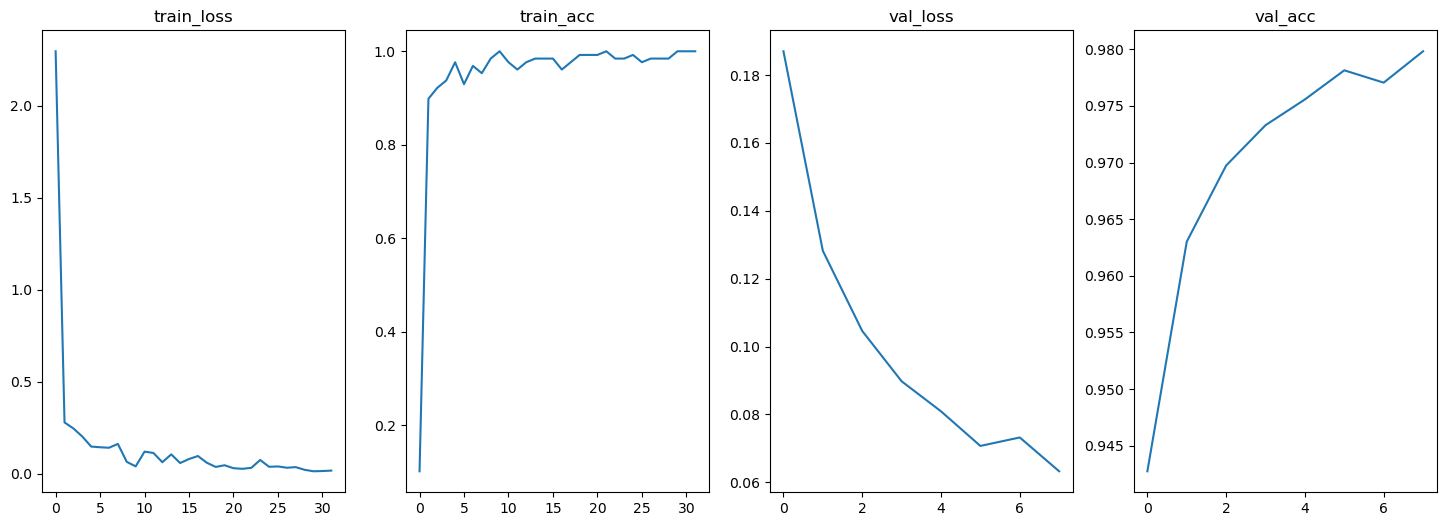

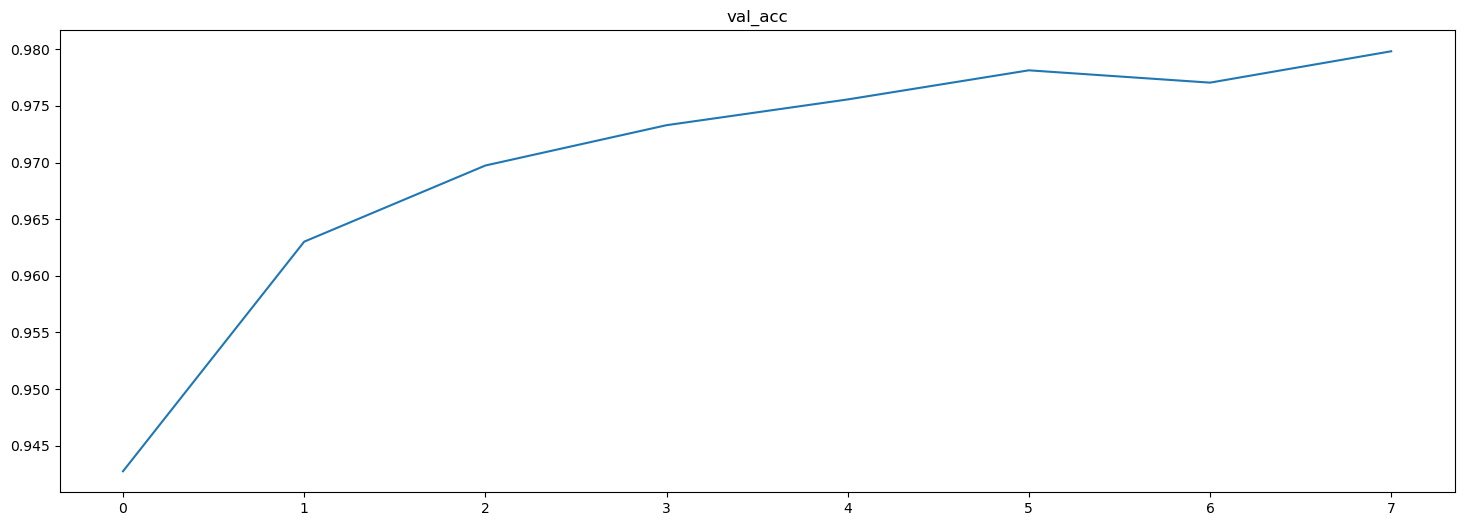

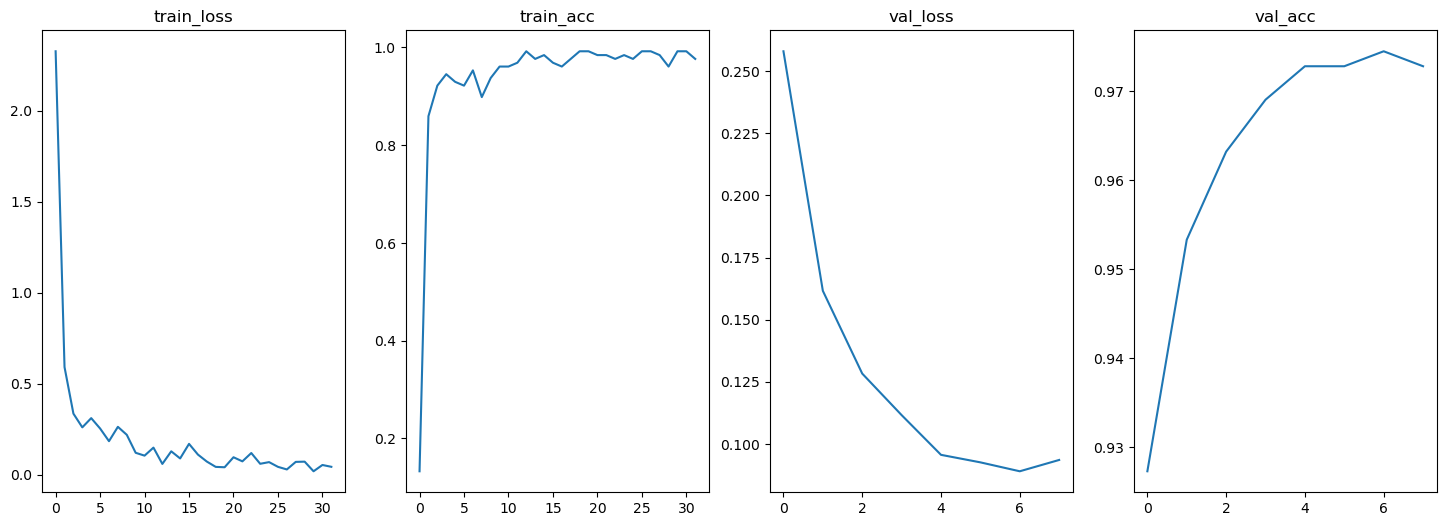

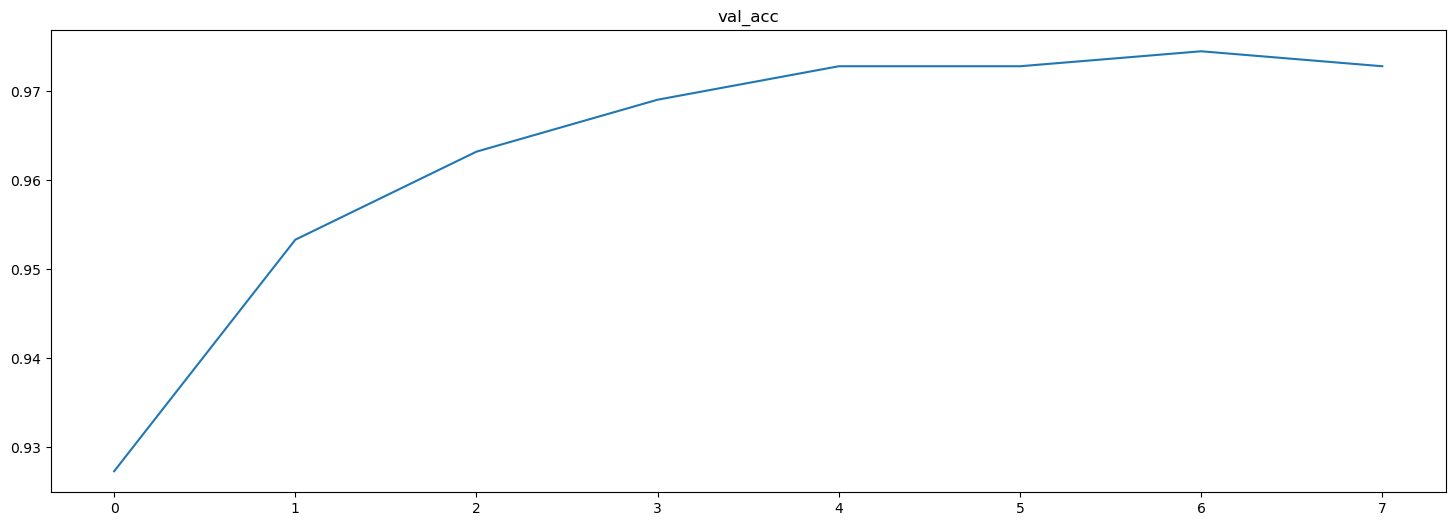

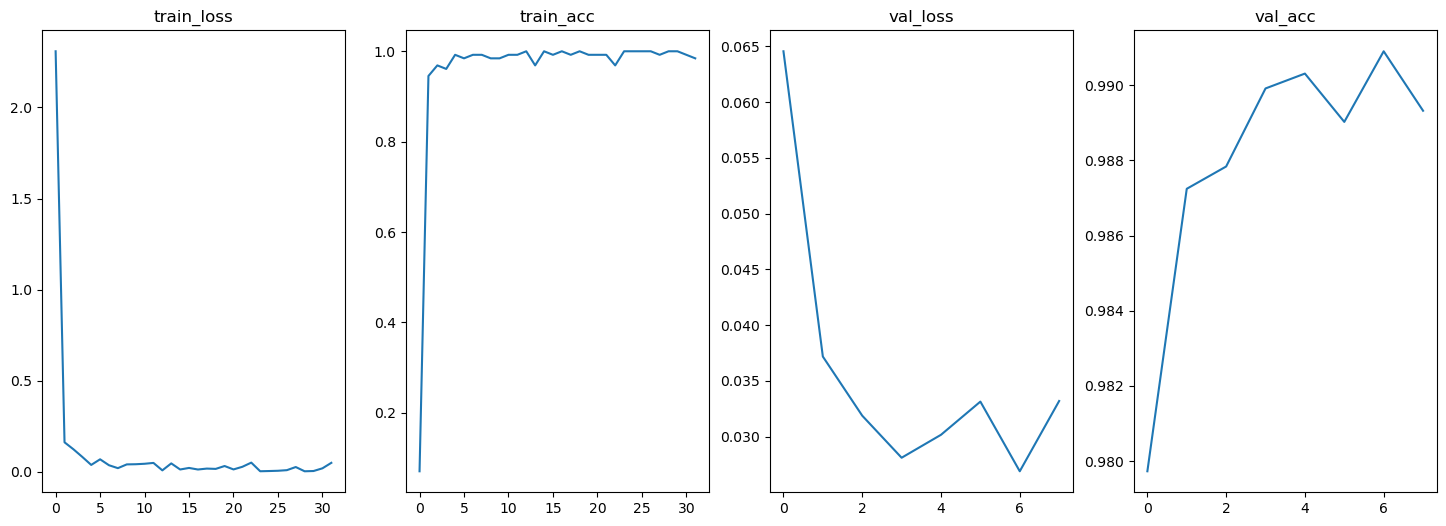

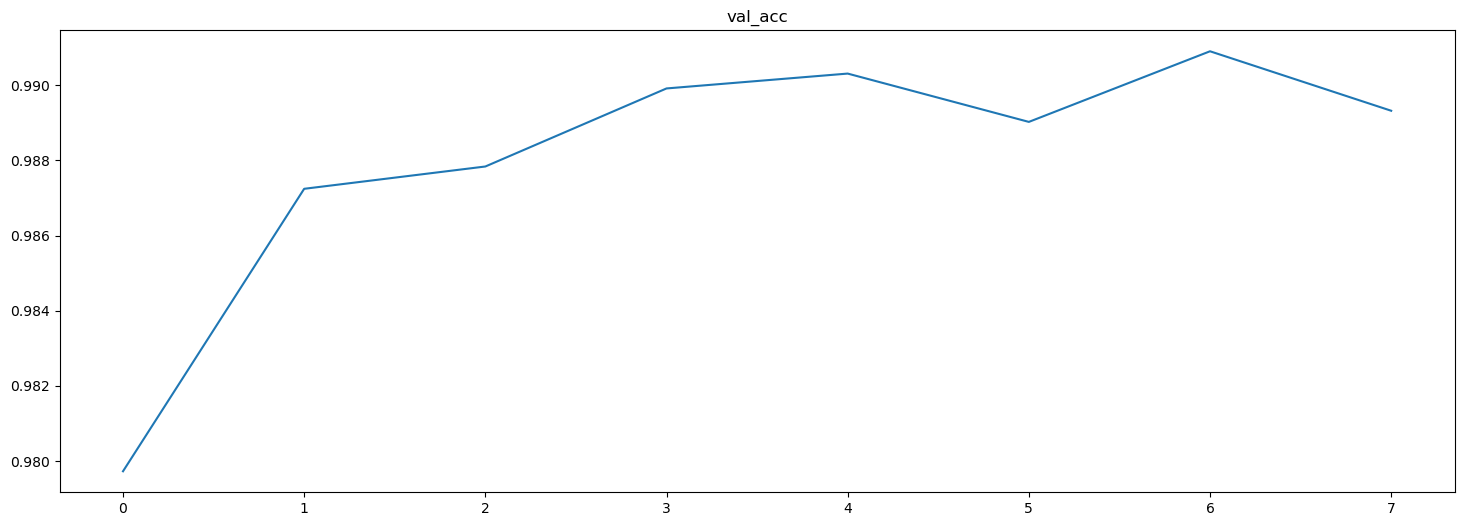

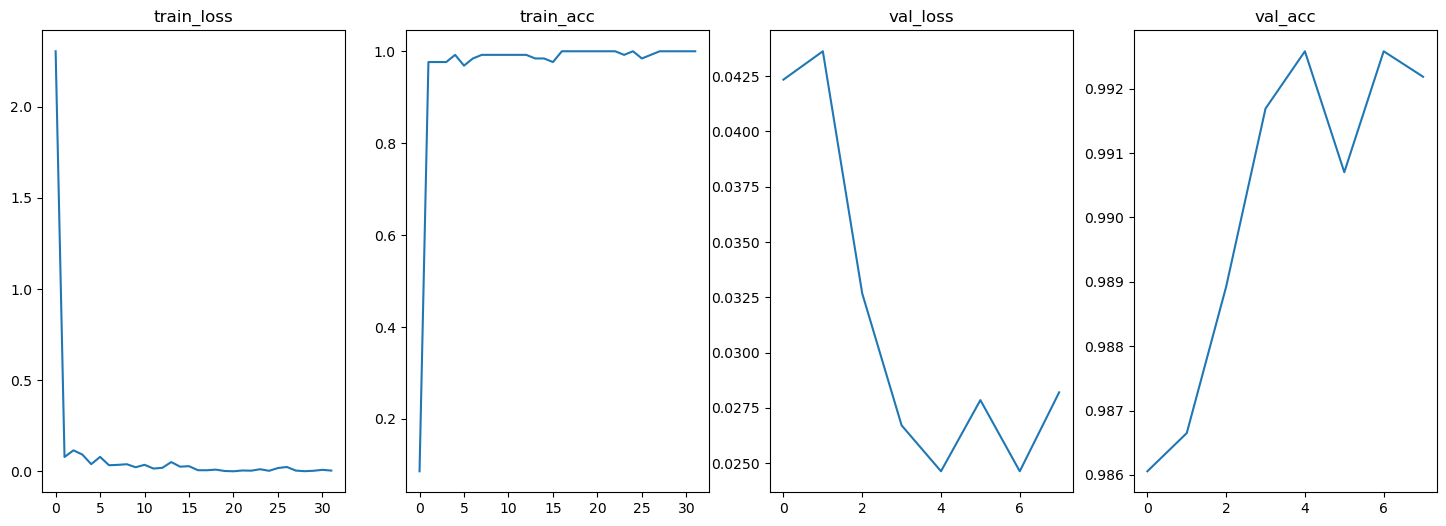

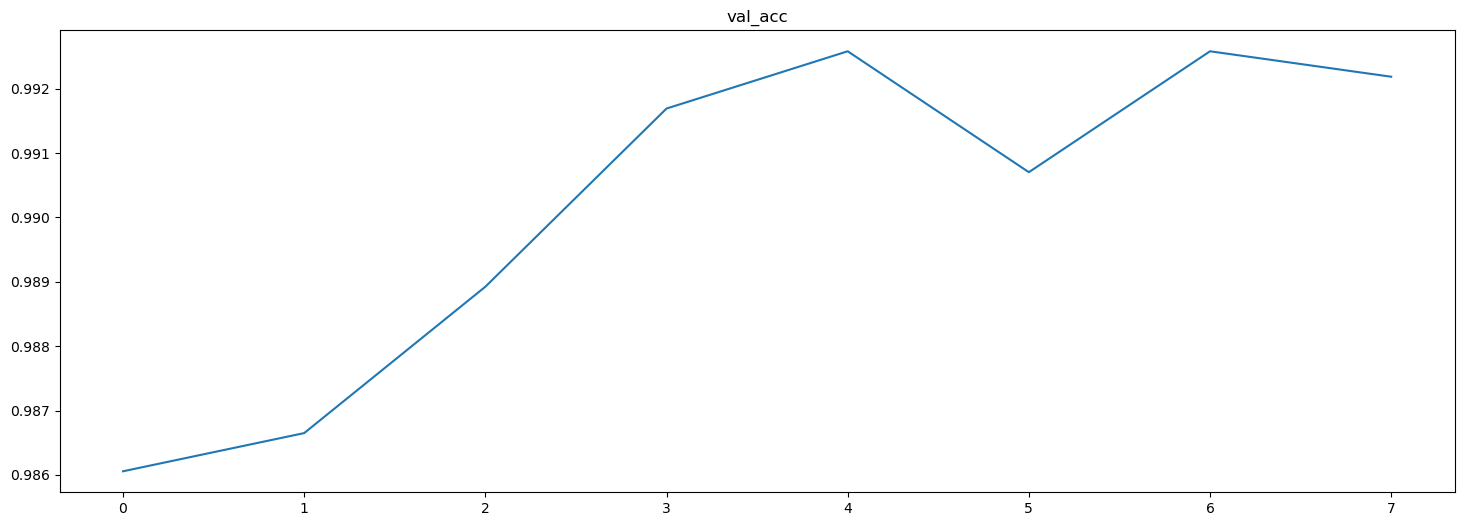

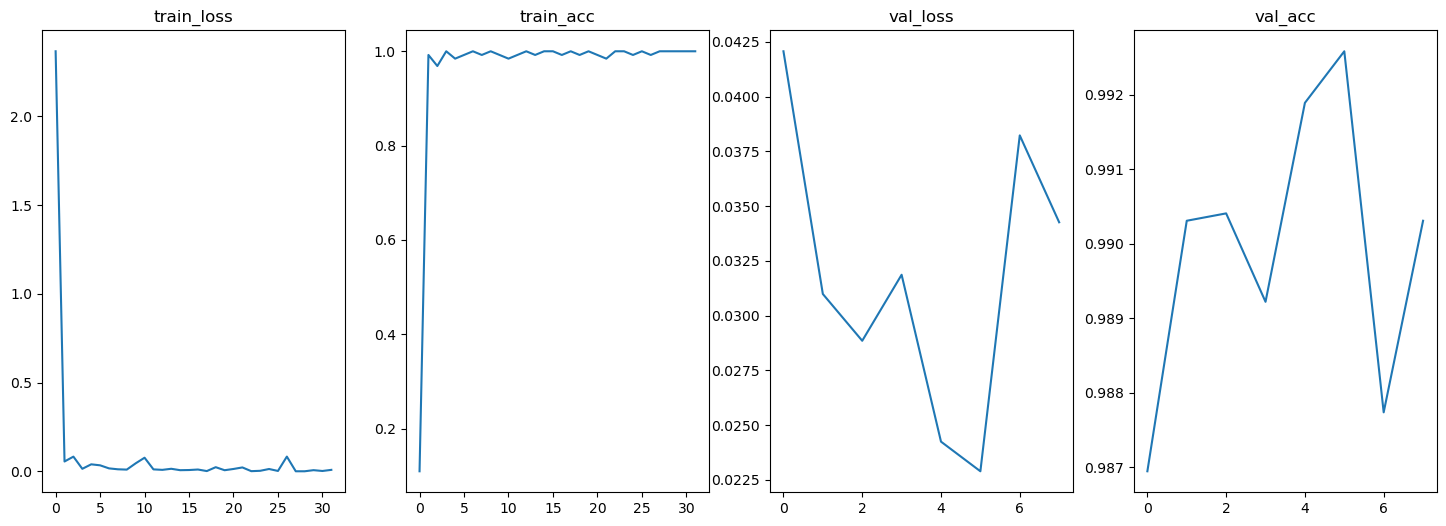

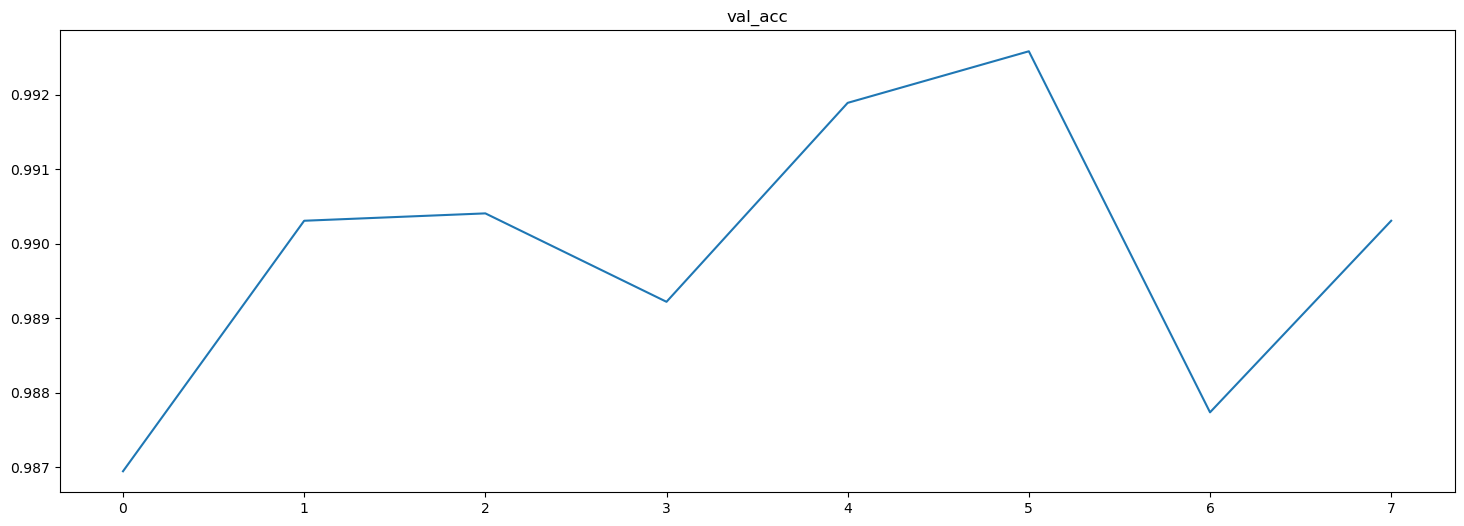

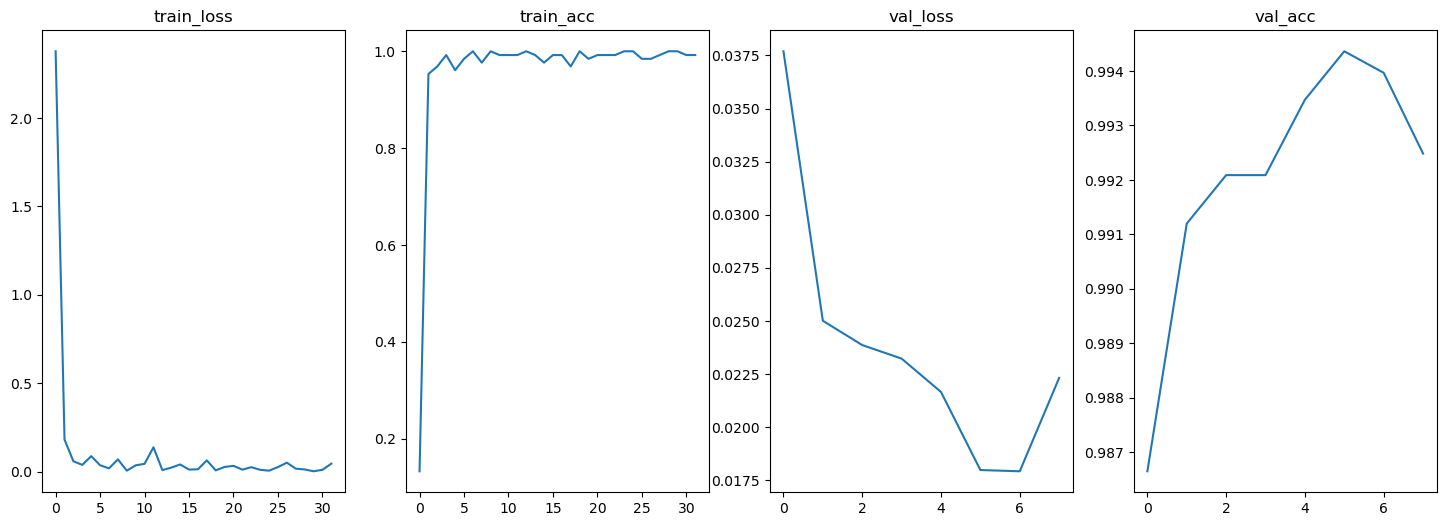

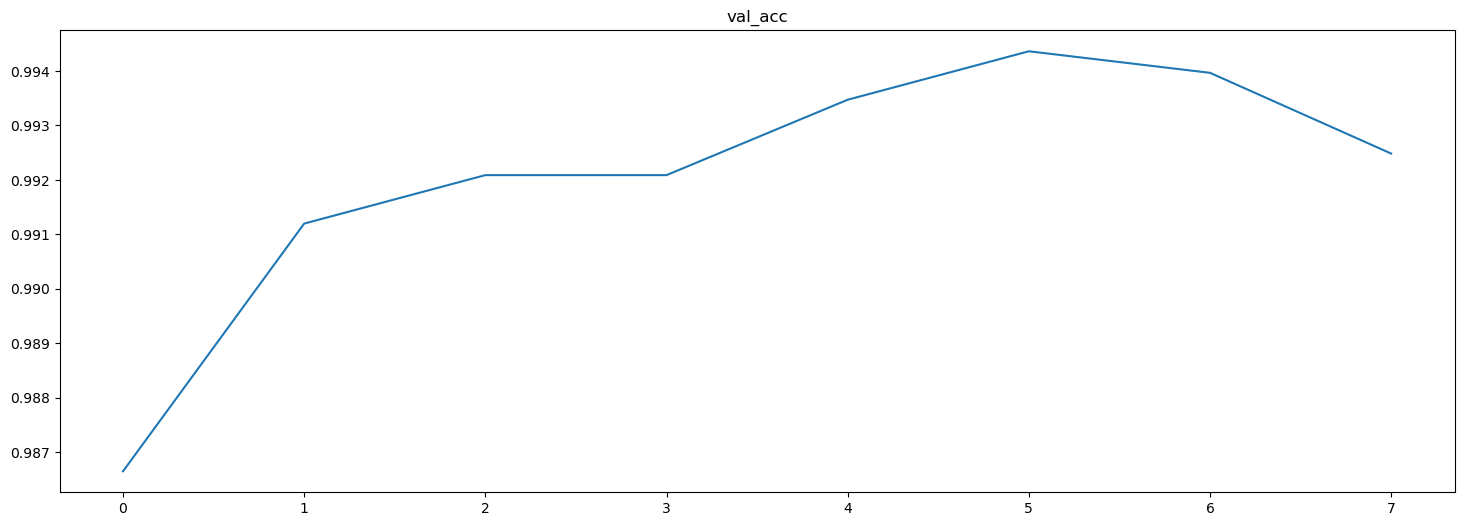

In [25]:

fc1 = FC_1().to(Device)
f1_acc = train(fc1, 'fc1')
fc2 = FC_2().to(Device)
f2_acc = train(fc2, 'fc2')
con_b = Conv_net_base().to(Device)
con_b_acc = train(con_b, 'con_b')
con_p = Conv_net_plus().to(Device)
con_p_acc = train(con_p, 'con_p')
con_pb = Conv_net_plus_bn().to(Device)
con_pb_acc = train(con_pb, 'con_pb')
con_pbd = Conv_net_plus_bn_dropout().to(Device)
con_pbd_acc = train(con_pbd, 'con_pbd')
print(f1_acc, f2_acc, con_b_acc, con_p_acc, con_pb_acc, con_pbd_acc)